In [1]:
#%windir%\System32\cmd.exe "/K" C:\ProgramData\Anaconda3\Scripts\activate.bat C:\ProgramData\Anaconda3 run anaconda 
# env on wind server
%matplotlib inline

from preprocess import *
from utils import *
import TemporalClusterer as tc
import numpy as np
import pandas as pd
import datetime

import umap
import hdbscan

import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.cluster.hierarchy import dendrogram, linkage

import sys
import os

%load_ext autoreload
%autoreload 2

In [4]:
sns.set(style='white', context='notebook', rc={'figure.figsize': (14, 10)})
thresh=10 
act_threshold=4
aggr=15*60

data='Z:/SECT/';

In [6]:
file_list = [x.date().isoformat() for x in pd.date_range('2020-02-08', '2020-02-15')]
days = len(file_list)

df = pd.DataFrame()
for file_name in file_list:
    df = pd.concat([df, pd.read_pickle(data + file_name + '.pcl')], ignore_index=True)

df.head()

,ip,timestamp,origin,type,line
0,5.188.86.169,1581116394,[{'SW': ['Cowrie with Warden Filer output modu...,['Intrusion.UserCompromise'],0
1,185.209.0.64,1581116358,"[{'Type': ['Relay'], 'Name': 'cz.casablanca.wa...","['Attempt.Login', 'Test']",475
2,47.176.15.90,1581116359,"[{'Type': ['Relay'], 'Name': 'cz.casablanca.wa...","['Attempt.Login', 'Test']",1071
3,185.156.177.22,1581116362,"[{'Type': ['Relay'], 'Name': 'cz.casablanca.wa...","['Attempt.Login', 'Test']",1667
4,66.196.219.2,1581116357,"[{'Type': ['Relay'], 'Name': 'cz.casablanca.wa...","['Attempt.Login', 'Test']",2266


In [7]:
tfrom = datetime.datetime.fromisoformat('{} 00:00:00'.format(file_list[0])).timestamp()
tto = datetime.datetime.fromisoformat('{} 23:59:59'.format(file_list[-1])).timestamp()

df = df.loc[(df['timestamp'] >= tfrom) & (df['timestamp'] < tto), :]
df['slot']= ((df['timestamp']-tfrom)/aggr).astype(np.int)

df.head()

,ip,timestamp,origin,type,line,slot
9,185.197.74.246,1581119994,[{'SW': ['Cowrie with Warden Filer output modu...,"['Test', 'Intrusion.UserCompromise']",5187,3
255,5.188.62.13,1581116407,[{'SW': ['Cowrie with Warden Filer output modu...,['Intrusion.UserCompromise'],229518,0
257,5.182.39.96,1581116403,[{'SW': ['Cowrie with Warden Filer output modu...,['Intrusion.UserCompromise'],230977,0
259,5.188.86.219,1581116409,[{'SW': ['Cowrie with Warden Filer output modu...,['Intrusion.UserCompromise'],232847,0
314,5.188.87.51,1581120004,[{'SW': ['Cowrie with Warden Filer output modu...,"['Test', 'Intrusion.UserCompromise']",271133,4


In [8]:
dfip = pd.DataFrame()
dfip['list'] = df.groupby('ip')['slot'].agg(lambda x: (list(x)))

dfip['count'] = dfip.list.apply(list.__len__)

dfip['list'] = df.groupby('ip')['slot'].agg(lambda x: list(x))
dfip['series'] = dfip.list.apply(get_bin_series, args=[np.ceil((days*24*3600)/aggr)]) 
dfip['blocks'] = dfip.series.apply(count_blocks)
dfip['activity'] = dfip.series.apply(np.sum)

,list,count,series,blocks,activity,class
ip,,,,,,
1.0.0.24,"[212, 214, 334, 348, 539, 680, 717]",7,"[False, False, False, False, False, False, Fal...",7,7,small
1.0.128.207,[303],1,"[False, False, False, False, False, False, Fal...",1,1,small
1.0.130.113,"[40, 71, 74, 83, 90]",5,"[False, False, False, False, False, False, Fal...",5,5,small
1.0.130.79,"[65, 76]",2,"[False, False, False, False, False, False, Fal...",2,2,small
1.0.131.152,"[202, 202]",2,"[False, False, False, False, False, False, Fal...",1,1,small


In [ ]:
#mark separate classes
dfip['class'] = dfip.activity.apply(lambda x: 'small' if x < thresh else 'too much' if x > 0.7*np.ceil((days*24*3600)/aggr) else 'good')

dfip.head()

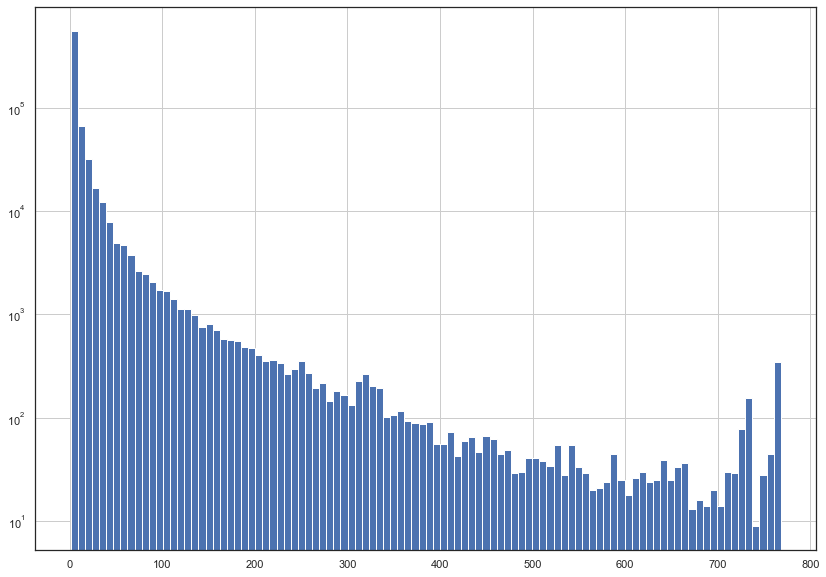

In [9]:

dfip.activity.hist(bins=100)
plt.yscale('log')


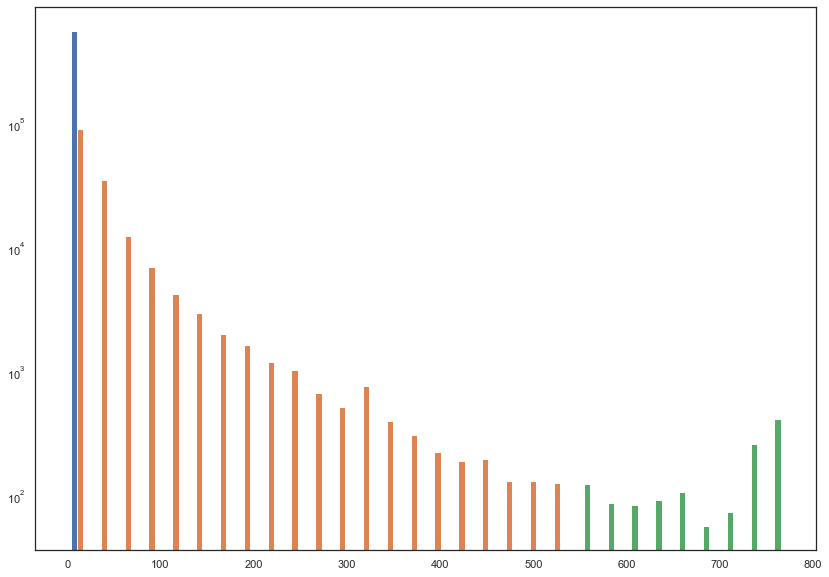

In [34]:
plt.hist([dfip.loc[dfip['class']==x,"activity"] for x in ['small','good','too much']], bins=30)
plt.yscale('log')

IP count reduction when activity threshold is set to 4
 ratio 0.22489768029318996
 ip count 162926


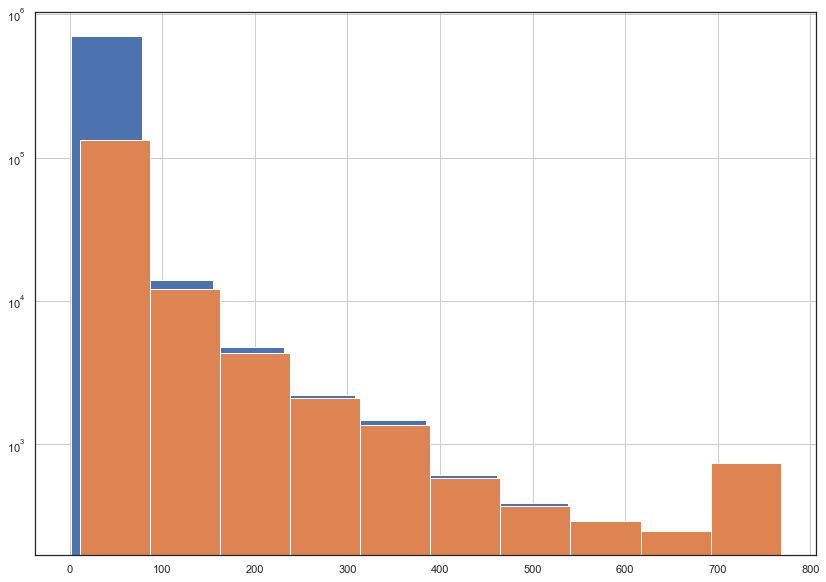

In [19]:
plt.figure()
dfip['activity'].hist()
plt.yscale('log')
dfip.loc[dfip['activity']>thresh,'activity'].hist()

act_threshold=4
print("IP count reduction when activity threshold is set to {}\n ratio {}\n ip count {}"
      .format(act_threshold, 
              len(dfip.loc[dfip['class']=='good', 'activity'])/len(dfip['activity']),
              len(dfip.loc[dfip['class']=='good'])))

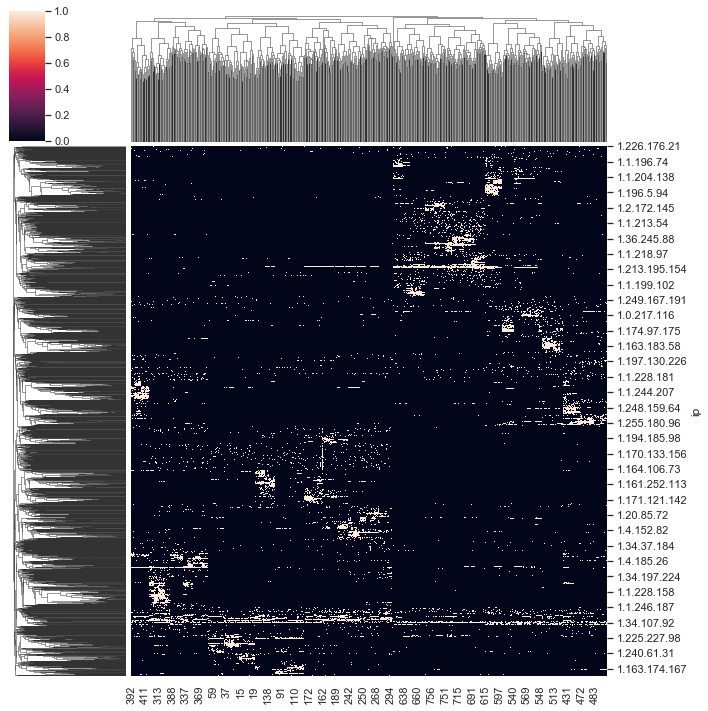

In [33]:
dfipgood=dfip.loc[dfip['class']=='good','series']

act = pd.DataFrame(data=np.stack(dfipgood), index=dfipgood.index)
sns.clustermap(act.head(2000), metric='jaccard')

There there is activity clusters of first 2000 ips

In [49]:
##Dokoncit ... pointa je, aby bolo vysvetlene filtrovanie dat
act['ip']=act.index
exmatch=act.groupby(list(range(0,np.int((days*24*3600)/aggr)))).agg([list, 'count'])

print(len(exmatch.loc[exmatch['ip']['count']>1,:])/len(dfip))

0.003698003299077225


2679
0.20    1.0
0.80    1.0
0.95    1.0
0.99    2.0
Name: count, dtype: float64
                   0      1      2      3      4      5      6      7    \
list                                                                      
147.139.162.29   False  False  False  False  False  False  False  False   
113.168.193.213  False  False  False  False  False  False  False  False   
116.110.13.19    False  False  False  False  False  False  False  False   
186.67.130.155   False  False  False  False  False  False  False  False   
175.181.98.89    False  False  False  False  False  False  False  False   

                   8      9    ...   758   759   760   761   762    763  \
list                           ...                                        
147.139.162.29   False  False  ...  True  True  True  True  True   True   
113.168.193.213  False  False  ...  True  True  True  True  True   True   
116.110.13.19    False  False  ...  True  True  True  True  True   True   
186.67.130.155   F

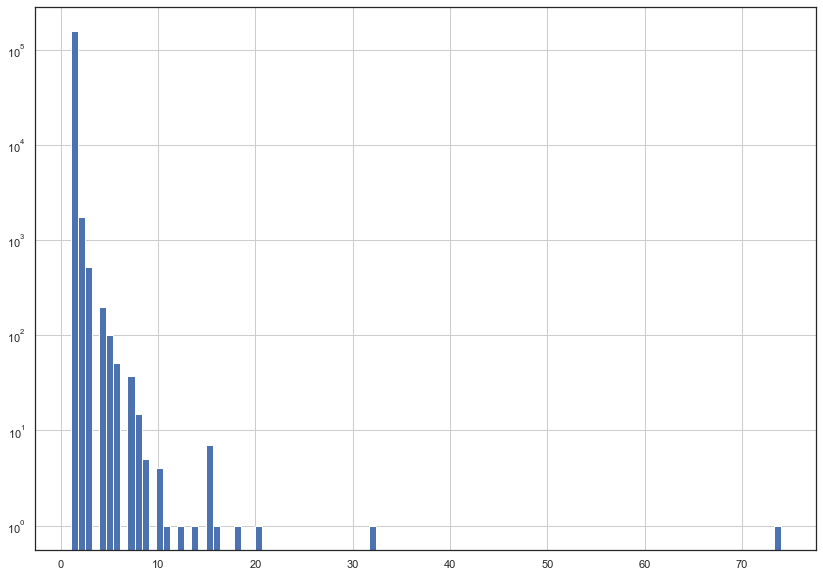

In [60]:
exmatch['ip']['count'].hist(bins=100)
plt.yscale('log')
print(len(exmatch.loc[exmatch['ip']['count']>1,:]))

exmatch.loc[exmatch['ip']['count']>1,:]
print(exmatch['ip']['count'].quantile([0.2,0.8,0.95,0.99]))

gact=pd.DataFrame(data=np.stack(exmatch.loc[exmatch['ip']['count']>1,:].index.to_flat_index()), 
                  index=exmatch.loc[exmatch['ip']['count']>1,:]['ip']['list'].apply(lambda x: x[0]))

print(gact.head())

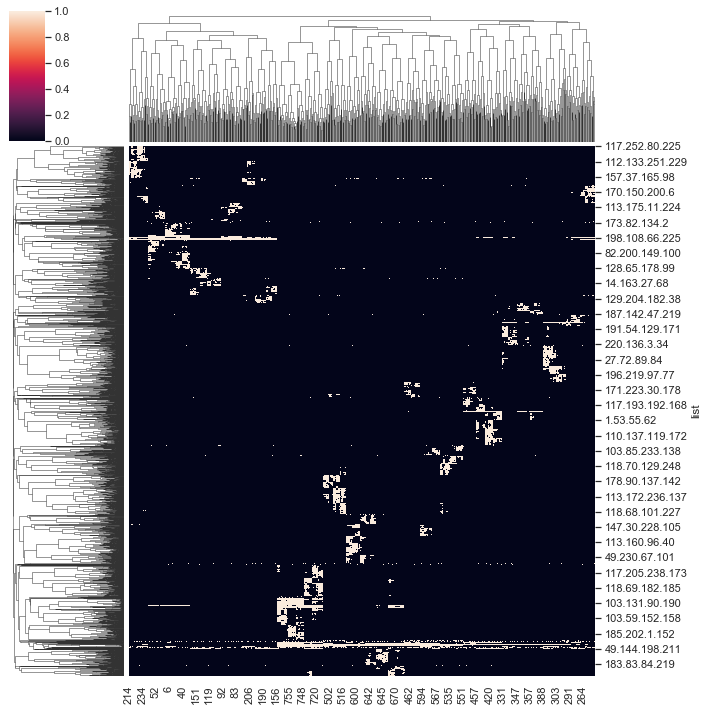

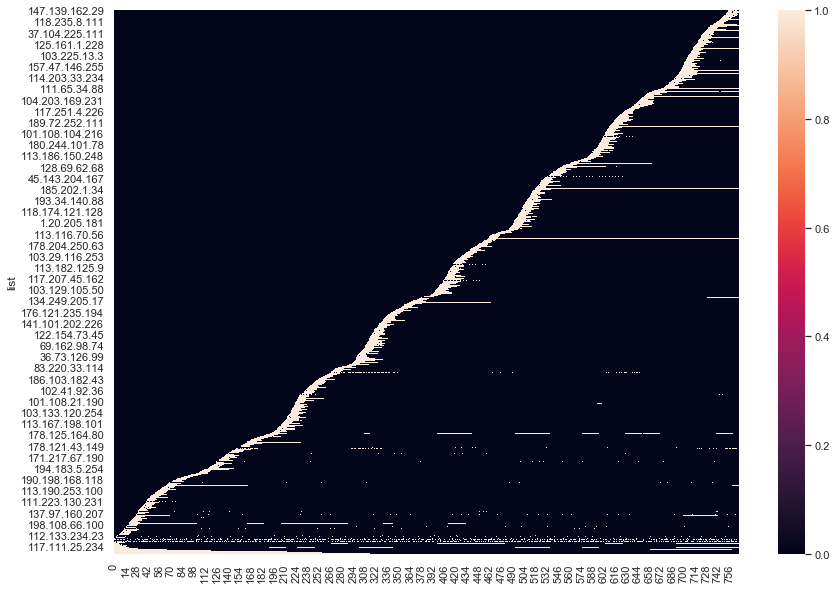

In [63]:
sns.clustermap(gact, metric='jaccard')
plt.figure()
sns.heatmap(gact)

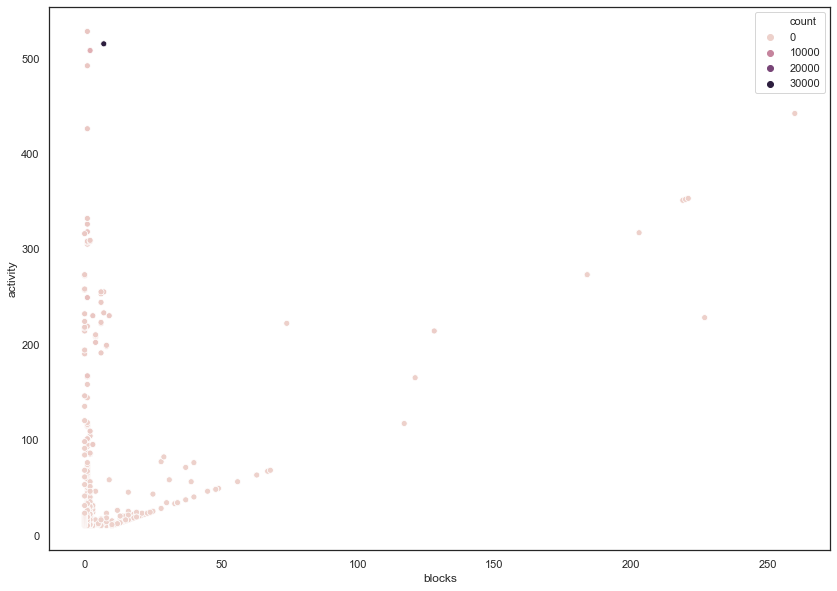

In [65]:
sns.scatterplot(data=dfip.loc[gact.index,:],x='blocks',y='activity',hue='count')
#this is quite interesting

In [ ]:
test = pd.DataFrame(data=np.stack(exmatch.index.to_flat_index()), index=exmatch[:])

ctest.index=range(0,len(ctest))
cg=sns.clustermap(ctest.sample(2000), metric='jaccard')

groups = pd.DataFrame(data=exmatch.values)
groups['size'] = groups.apply(lambda x: len(x[0]), axis=1)

groups.index=groups[0].apply(lambda x: x[0])
groups['activity']=dfip['activity']

In [ ]:
groups['size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>1, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>2, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>act_threshold, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>20, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>100, 'size'].hist(bins=list(range(0,800,8)))

#groups.loc[(groups['activity']>act_threshold)&(groups['size']>15), 'size'].hist(bins=list(range(0,800,8)))

plt.yscale('log')

Predošlý graf je zaujímavý. Ukazuje, ako sa lýšia veľkosti klastrov (presné zhody) a ich rozloženie. 
Ak sa okrem veľkosti grafov vezme do úvahy aj minimálna aktivita (náhodnosť klesá), vidno rozkol v distribúcií.

Pravdepodobne, nízka miera aktivity vedie na veľké množstvo náhodných korelácií, veľké skupiny (modrá)
Artefakty ? Ako by mohli vyzerať ? Ako filtrovať ? 
Graf je dekomponavaný podľa aktivity (počet slotov kde sa komnunikovalo)

modré su náhodné korelácie (x je počet v skupine s presnou zhodou)
Rationale - s počtom slotov aktivity rastie priestor v kt. sa IP môzu rozprestireť, pst. náhodnej korelacie klesá. 
!!!

In [ ]:
act['ip']=act.index
act = act.loc[dfip['count']>1]
exmatch=act.groupby(list(range(0,np.int((days*24*3600)/aggr)))).agg(list)
print(len(exmatch)/len(act))

test = pd.DataFrame(data=np.stack(exmatch.index.to_flat_index()), index=exmatch[:])
#test.head()

groups = pd.DataFrame(data=exmatch.values)
groups['size'] = groups.apply(lambda x: len(x[0]), axis=1)

groups.index=groups[0].apply(lambda x: x[0])
groups['activity']=dfip['activity']

In [ ]:
groups['size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>1, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>2, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>act_threshold, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>20, 'size'].hist(bins=list(range(0,800,8)))
groups.loc[groups['activity']>100, 'size'].hist(bins=list(range(0,800,8)))

#groups.loc[(groups['activity']>act_threshold)&(groups['size']>15), 'size'].hist(bins=list(range(0,800,8)))

plt.yscale('log')

In [ ]:
groups['size'].hist(bins=100)
plt.yscale('log')

In [ ]:
gseries = pd.DataFrame()
gseries['list'] = dfip.loc[groups.index,'list'].copy()

print(gseries.head())
print(gseries.size)
#TODO - finish this!
#Set division to close to independant components
#Now loop through
gseries['ip'] = (gseries.index)
gseries.index = gseries.ip.values
filt=gseries.groupby('ip').agg('count')
gseries = gseries.loc[filt>1,:]

MX = np.int((tto-tfrom)/(aggr*4))

gseries['slot4'] = gseries['list'].apply(lambda x: np.divide(x,MX).astype(np.int))
print(gseries.head())
print(MX)

In [ ]:
gby = pd.DataFrame(data=np.stack(gseries['slot4'].apply(get_bin_series, args=[4+1])), index=gseries['ip'])
gby['ip'] = gseries['ip']
a=gby.groupby(list(range(0,np.int(4+1)))).agg('count')
print(a)

In [ ]:
gseries['slot8'] = gseries['list'].apply(lambda x: np.divide(x,MX/2).astype(np.int))
gby = pd.DataFrame(data=np.stack(gseries['slot8'].apply(get_bin_series, args=[2*4+1])), index=gseries['ip'])
gby['ip'] = gseries['ip']
a=gby.groupby(list(range(0,np.int(2*4+1)))).agg('count')
print(a)


In [ ]:
d = act.loc[dfip['activity']>10,:].iloc[:30000,0:-1]

embedding = umap.UMAP(n_components=4).fit_transform(d)
sns.pairplot(data=embedding)

In [ ]:

g = sns.PairGrid(pd.DataFrame(embedding))
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

In [ ]:
d.shape

In [ ]:
len(dfip['activity']>10)
dfip.loc[dfip['activity']>10,'activity'].hist(bins=100)
print(dfip.loc[dfip['activity']>10,'activity'].shape)

In [ ]:
d.loc[dfip['activity']>10,:].to_csv('./15minmat.csv')
